<a href="https://colab.research.google.com/github/sallez9/SCTPAIMLcapstone/blob/main/cvapplecapstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Computer Vision for Produce Quality in Fruit**

Reference:

* TensorFlow/Keras documentation: https://www.tensorflow.org/
* Deep Learning book (Ian Goodfellow, Yoshua Bengio, and Aaron Courville): http://www.deeplearningbook.org/
* Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow (Aurélien Géron)
* Multilabel Fruits Classification | CNN | Keras' kaggle.com Devashree Madhugiri https://www.kaggle.com/code/devsubhash/multilabel-fruits-classification-cnn-keras
* SVMClassification_OnAppledatasetOpenCV https://github.com/sarathbabu123/SVMClassification_OnAppledatasetOpenCV

This project proposes a method involving the deep learning technique which is CNN for feature extraction and classification of defect fruits. It is one of the applications of image classification problems. This approach uses an RGB channel image of the fruit under examination.

Use Case: Detecting Defect Fruits

With Deep Learning's capabilities, fruit classification can be well implemented as a replacement of traditional manual methods in the agricultural, horticultural and botany domains. By utilizing these models,we can introduce efficiency and accuracy into various fruit-related processes.



# **1.1 Importing Required Libraries and Packages**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import sys
import pandas as pd
import keras
import seaborn as sns
import pickle
#import cv2 as cv
import os
import shutil
import uuid
# avoid warnings
import warnings
warnings. filterwarnings('ignore')

from sklearn.svm import SVC
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# Clone the repository
os.system('git clone https://github.com/sallez9/SCTPAIMLcapstone.git')

print("Dataset downloaded successfully!")

Dataset downloaded successfully!


# **1.2 Load and Preprocess Dataset**

**Description of the Dataset**
The dataset used in this project is derived from the [Fruits 360 dataset](https://github.com/fruits-360) (Version: 2020.05.18.0), which is a comprehensive collection of images featuring various fruits and vegetables. The dataset is publicly available under the CC-BY-SA 4.0 license, allowing for both academic and commercial use with appropriate attribution.

This dataset is organized into three main subsets: training, test, and validation, with a diverse array of classes representing different types of fruits and vegetables. For instance, in the training set, you may find separate folders for specific fruit classes, such as "apple red," "apple hit," and "apple rotten." This granularity allows for the exploration of multiple characteristics, such as freshness or damage, within a single fruit type.

In [3]:
import pathlib

data_dir = 'SCTPAIMLcapstone/dataset'
data_dir = pathlib.Path(data_dir).with_suffix('')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1695


# **1.3 Sorting and Filtering Dataset**

**Findings and Techniques**
To prepare the dataset for our project focused on produce quality inspection for fresh or defective apples, we needed to consolidate certain classes. Specifically, we aimed to 1. merge the "apple hit" and "apple rotten" classes into a single category, which we termed "apple defect" and 2. merge the apple red 1, 2 and 3 classes into a single category, which we termed "apple fresh". This allowed us to simplify the task of classifying defect versus fresh apples.
To achieve this, we used Python scripting to rename and merge the files from the "apple hit" and "apple rotten" folders into one unified directory. This step was crucial for balancing the dataset and ensuring that the classifier could distinguish between healthy and defective fruits effectively. These steps provided a solid foundation for the subsequent machine learning and computer vision tasks, ultimately contributing to more accurate fruit quality classification.
The preprocessing involved:
1. **File Renaming**: To avoid filename conflicts, we automatically renamed the files during the merging process, ensuring unique identifiers for each image.
2. **Merging files and Renaming Classes**: We wrote Python code to combine the images from the "apple hit" and "apple rotten" classes into "apple defect". and similarly for "apple fresh".

In [5]:
!mkdir SCTPAIMLcapstone/dataset/apple_fresh
!mkdir SCTPAIMLcapstone/dataset/apple_defect

# Paths to the merged class folders
fresh_folder_path = 'SCTPAIMLcapstone/dataset/apple_fresh'
defect_folder_path = 'SCTPAIMLcapstone/dataset/apple_defect'

# Paths of individual folders that need to be merged into the two classes
folders_to_replace = {
    fresh_folder_path: [
        'SCTPAIMLcapstone/dataset/apple_red_1',
        'SCTPAIMLcapstone/dataset/apple_red_2',
        'SCTPAIMLcapstone/dataset/apple_red_3'
    ],
    defect_folder_path: [
        'SCTPAIMLcapstone/dataset/apple_hit_1',
        'SCTPAIMLcapstone/dataset/apple_rotten_1'
    ]
}

In [6]:
#file rename files with replace folder instead of only merge files into folder method
# Function to rename files in a folder by adding a prefix, suffix, and ensuring unique names
def rename_files_in_folder(folder_path, prefix='', suffix=''):
    with os.scandir(folder_path) as entries:
        for entry in entries:
            if entry.is_file():
                name, ext = os.path.splitext(entry.name)
                unique_id = uuid.uuid4().hex[:8]  # Generate a short unique identifier
                new_name = f"{prefix}{name}_{unique_id}{suffix}{ext}"
                os.rename(entry.path, os.path.join(folder_path, new_name))

In [7]:
# Function to replace files from source folder into destination folder
def replace_files(src_folder, dest_folder):
    with os.scandir(src_folder) as entries:
        for entry in entries:
            if entry.is_file():
                dest_file_path = os.path.join(dest_folder, entry.name)
                # If the file exists in the destination folder, delete it before replacing
                if os.path.exists(dest_file_path):
                    os.remove(dest_file_path)
                shutil.move(entry.path, dest_file_path)
        # Erase the source directory after replacing files
        shutil.rmtree(src_folder)

In [8]:
# Rename files within the main class folders with unique names
rename_files_in_folder(fresh_folder_path, prefix='fresh_')
rename_files_in_folder(defect_folder_path, prefix='defect_')

# Replace the files in the main class folders with files from the additional folders
for dest_folder, src_folders in folders_to_replace.items():
    for src_folder in src_folders:
        # Rename files before replacing with unique names
        rename_files_in_folder(src_folder, prefix=os.path.basename(dest_folder) + '_')
        replace_files(src_folder, dest_folder)

print("Files have been uniquely renamed and replaced in two classes: 'fresh' and 'defect'.")

Files have been uniquely renamed and replaced in two classes: 'fresh' and 'defect'.


In [9]:
#load the dataset with tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generators for training and validation
# Preprocess the image to match the input shape expected by the model

data_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
img_height = 180
img_width = 180

# **1.4 Exploring and Preparing Dataset**

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1695 files belonging to 2 classes.
Using 1356 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1695 files belonging to 2 classes.
Using 339 files for validation.


In [12]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['apple_defect', 'apple_fresh']


In [13]:
!ls SCTPAIMLcapstone/dataset

apple_defect  apple_fresh


In [16]:
# List the first few images in the 'apple_defect' class folder
defect_dir = os.path.join(data_dir, 'apple_defect')
defect_images = os.listdir(defect_dir)
print("Apple defect Images:", defect_images[:2])  # Print first 2 images in the Apple defect directory

Apple defect Images: ['apple_defect_r2_146_e90dcbf7.jpg', 'apple_defect_r0_78_63be4ae6.jpg']


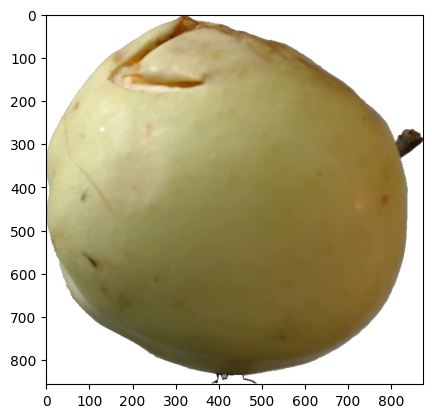

In [18]:
# Load an example image
# with PIL
from PIL import Image

import matplotlib.pyplot as plt

image_path = os.path.join(data_dir, 'apple_defect', 'apple_defect_r2_146_e90dcbf7.jpg')  # Adjust the path as necessary
image = Image.open(image_path)

# Display the image with matplotlib
plt.imshow(image)
#plt.axis('off')  # Hide axes
plt.show()

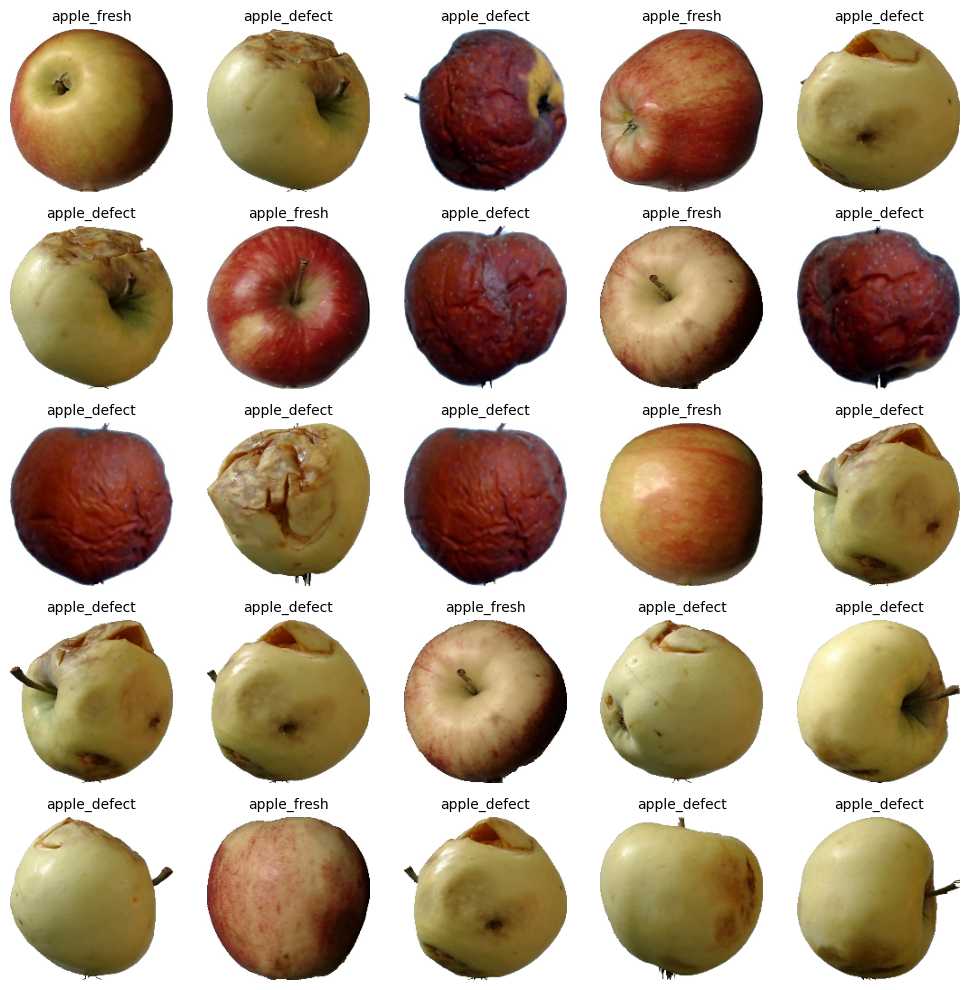

In [19]:
#visualizing sample images from the dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(9):
    for i in range(25):
        ax = plt.subplot(5,5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]], fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()

# **2.1 Defining the CNN**

**Basic CNN Model**
Let us now define our CNN model with the Sequential API in Keras using the input_shape specified. This model will consist of multiple Conv2D and MaxPooling2D layers, followed by a Flatten layer, two Dense layers with dropout regularization, and a finally a Dense layer with softmax activation for multi-class classification Also, the n_classes will represent the number of output classes.
The CNN model proposed comprises several layers, including a convolutional layer,activation layer, pooling layer, dropout layer, flatten layer, fully connected layer, and output layer.Three convolutional layers were constructed using different convolution filters with a size of 3 ∗3.The input image used for training the model was of size 180 ∗180 ∗3. Additionally, a max poolinglayer was implemented with a pool size of 2 ∗2. Finally, a dropout, flatten and dense layer were addedand the model was compiled to give the results implemented. The accuracy score achieved with this model was about 99% as shown in figure above.

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.Input(shape=(img_height, img_width, 3)),  # Define the input shape here
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [21]:
#CNN model
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

# **2.2 Choice of Optimizer**

Adam optimizer is a good choice for computer vision on defect apples due to its efficiency, effectiveness, and ability to handle complex models and noisy data. Its adaptive learning rate, momentum, and computational efficiency make it a suitable choice for this specific task.

**1. Adaptive Learning Rate:** Adam automatically adjusts the learning rate for each parameter during training, adapting to the curvature of the loss landscape. This helps it converge faster and avoid getting stuck in local minima.

**2. Momentum:** Adam incorporates momentum, which helps it escape from saddle points and flat regions. This means it can more effectively navigate the complex optimization landscape of computer vision tasks.

**3. Computational Efficiency:** Adam is relatively computationally efficient compared to other optimization algorithms, making it suitable for large-scale computer vision tasks.

**4. Stability:** Adam is generally more stable than other algorithms, especially in the presence of noisy gradients. This is particularly important in computer vision, where the data can be noisy and the models can be complex.

**5. Popularity and Ease of Use:** Adam has become a popular choice among researchers and practitioners due to its effectiveness and ease of implementation. It is often the default optimizer in many deep learning frameworks.

**6. Specific to Defect Apple Detection:** While the general reasons mentioned above apply to computer vision tasks in general, Adam's performance might be particularly beneficial for defect apple detection due to the following:

* **Complex Features:** Defect apple detection often involves identifying subtle visual features, which can be challenging for optimization algorithms. Adam's adaptive learning rate and momentum can help it navigate this complex landscape effectively.
* **Large Datasets:** If you have a large dataset of defect apple images, Adam's computational efficiency can be a significant advantage.
* **Noisy Data:** Defect apple images might contain noise due to various factors like lighting conditions, camera quality, and image preprocessing. Adam's stability can help it cope with this noise.


In [22]:
# specifying the optimizer and model metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# **2.3 Training the Model**

In [23]:
epochs = 10
history = model.fit(# saving the model training history
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.6366 - loss: 0.7806 - val_accuracy: 0.9941 - val_loss: 0.0515
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9756 - loss: 0.0728 - val_accuracy: 0.9941 - val_loss: 0.0178
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9936 - loss: 0.0276 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9952 - loss: 0.0168 - val_accuracy: 1.0000 - val_loss: 8.2475e-04
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 1.6097e-04
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9987 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9944 - loss: 0.0113 - val_accuracy: 1.0000 - val_loss: 5.0373e-04
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000

# **2.4 Checking for Overfitting**

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy'
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]  # Add early stopping to the callbacks list
)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 1.0000 - loss: 1.4210e-04 - val_accuracy: 1.0000 - val_loss: 4.6667e-04
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 1.0000 - loss: 4.6069e-04 - val_accuracy: 1.0000 - val_loss: 3.8755e-05
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 1.0000 - loss: 8.6507e-05 - val_accuracy: 1.0000 - val_loss: 2.8475e-05
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 1.0000 - loss: 3.4390e-05 - val_accuracy: 1.0000 - val_loss: 3.7034e-05
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 1.0000 - loss: 2.7139e-05 - val_accuracy: 1.0000 - val_loss: 8.0806e-06
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 1.0000 - loss: 2.3968e-05 - val_accuracy: 1.0000 - val_loss: 1.3364e-05
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 1.0000 - loss: 1.2936e-05 - val_accuracy: 1.0000 - val_loss: 8.3616e-06
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 

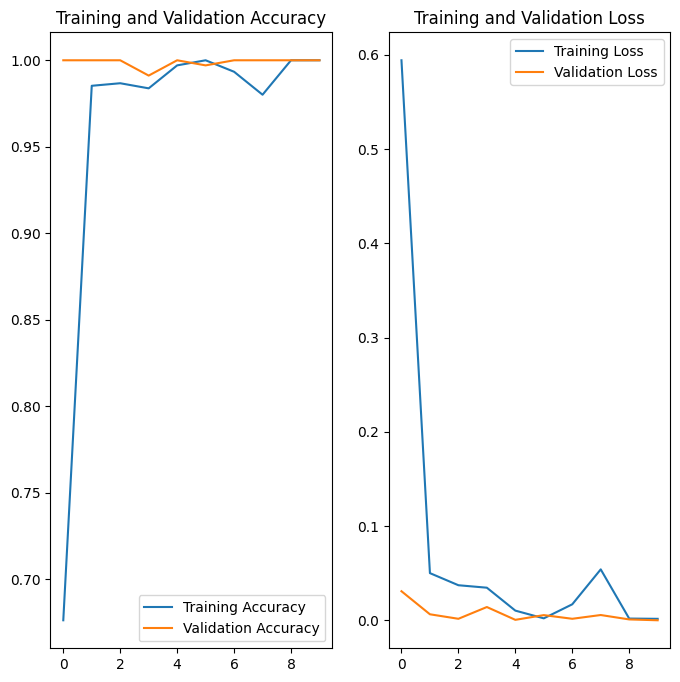

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Insights from the Training and Validation Accuracy/Loss Plot**

If the deep learning CNN model gets too complex, it is likely to suffer from overfitting. Overfitting indicates that the model begins to memorize the training data instead of learning general patterns. A possible indicator of this is highly accurate model i.e. training and validation accuracies >90%. This also indicates that the model is biased to the images training data and a poor generalization on unseen images.

Let us plot the accuracy and loss curves to visualize the model training process.

Overall, the model appears to be performing well with minor overfitting. Noted that the dataset size is rather small.

**Accuracy**: The model seems to be performing well, with both training and validation accuracy reaching around 0.95. This indicates that the model is learning effectively and generalizing well to unseen data.
**Loss**: The training and validation loss both decrease over time, which is a good sign as it means the model is making fewer errors.

With more time and resource however, we can consider the model to be retrained for higher epochs with a different batch size for experimentation and evaluating a possible improvement in the model accuracy.

In [34]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,016,232 (45.84 MB)

 Trainable params: 4,005,410 (15.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,010,822 (30.56 MB)

# **3 Predicting unseen images from test dataset**

# **3.1 Create test data pipeline**

In [ ]:
# Load the full dataset
full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Calculate split sizes
total_size = len(full_ds)
test_size = int(0.1 * total_size)  # Assuming a 10% test split
val_size = int(0.2 * total_size)   # Assuming a 20% validation split

# Create test dataset
test_ds = full_ds.take(test_size)
train_val_ds = full_ds.skip(test_size)

# From remaining data, create training and validation datasets
train_ds = train_val_ds.skip(val_size)
val_ds = train_val_ds.take(val_size)


Found 1695 files belonging to 2 classes.


In [ ]:
#print test labels
ts_class_names = full_ds.class_names
ts_class_names

['apple_defect', 'apple_fresh']

# **3.2 Predicting a sample image**

first image to predict
actual label: apple_defect
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
This image most likely belongs to apple_defect with a 100.00 percent confidence.
predicted label: apple_defect


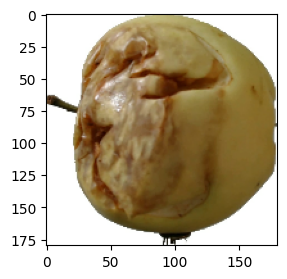

In [ ]:
# Fetching model predictions for sample image in test dataset
plt.figure(figsize=(3, 3))
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",ts_class_names[first_label])

    batch_prediction = model.predict(images_batch)
    score = tf.nn.softmax(batch_prediction[0])
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# **3.3 Batch prediction sample images**

In [ ]:
# Defining prediction function for validation images
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

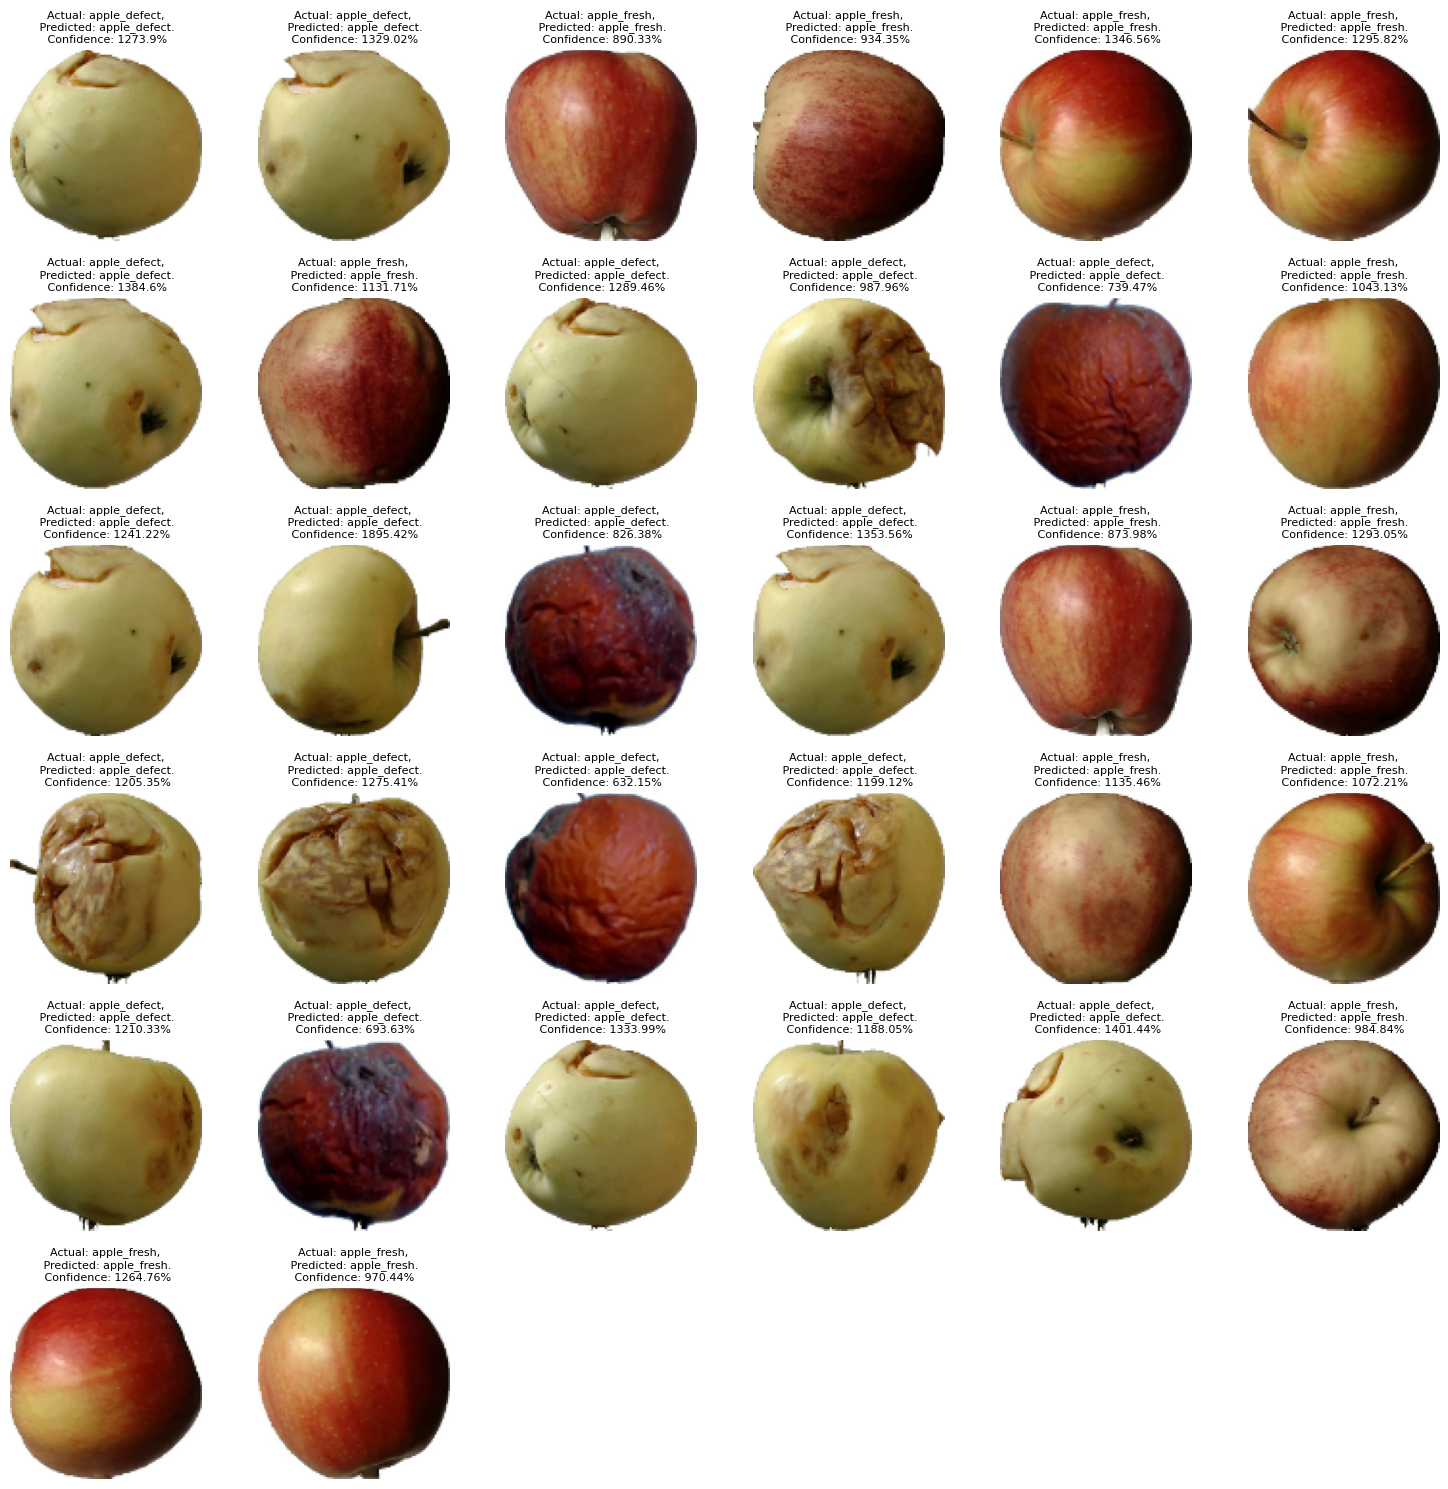

In [ ]:
plt.figure(figsize=(15, 15))

# Iterate over the batches and then the images to display their predictions
batch_size = 32
for images, labels in val_ds.take(12):
    for i in range(batch_size):
        if i >= len(images):
            break

        ax = plt.subplot(6, 6, i + 1)
        image = tf.image.resize(images[i], (100, 100))
        plt.imshow(image.numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%", fontsize=8)
        plt.axis("off")

    # If there are more than batch size images, break out of the loop
    if i >= batch_size - 1:
        break

# Hide any empty subplots
for i in range(i + 1, batch_size):
    plt.subplot(6,6, i + 1)
    plt.axis("off")

plt.tight_layout()
plt.show()

# **4.1 Confusion Matrix**

In [ ]:
confusion_matrix = np.zeros((num_classes, num_classes))

for images, labels in val_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    confusion_matrix += tf.math.confusion_matrix(labels, predicted_classes).numpy()

# Normalize confusion matrix if needed


In [ ]:
confusion_matrix

# **4.2 Confusion Matrix Heatmap**

In [ ]:
import seaborn as sns

sns.heatmap(confusion_matrix, annot=True, fmt='g',
            xticklabels=class_names, yticklabels=class_names, cmap='viridis')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **5 Conclusion**

We created a fairly accurate classifier in Keras.
The model accurately predicted most of the considered apple fresh or defect categories.
The model seems to incorrectly label where the apples appear similar in colors and shapes, they can be challenging for the model to classify. This can be improved by training the model with additional data using data augmentation in Keras
Experimenting with adding Batch normalization to the CNN layers to improve and stabilize the learning process
Adding more layers to the neural network
Adding L2 regularization
Experimenting with the dropout rate, learning rate
Apart from the above, the model does a good job of classifying